In [1]:
import math
import pandas as pd
import numpy as np
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from plotnine import *
import warnings
warnings.filterwarnings('ignore')
%pylab inline

In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define function to input a unique ID for the plate appearance
def pa_id_apply(df):
    # Get number of rows
    n_row = len(df.pitch_type)
    
    # Initialize list of plate appearances
    pa_ids = [1 for i in range(n_row)]
    
    # We know an at bat ends when the events column is not blank
    # In this case, the events column is a string
    # When it is blank, the events column has a float
    
    for i in range(1,n_row):
        if type(df.events[i]) == float:
            pa_ids[i] = pa_ids[i-1]
        else:
            pa_ids[i] = pa_ids[i-1] + 1
    
    # Add to dataframe
    df['pa_id'] = pa_ids            
    return df

# Define a function to calculate which pitch in the plate appearance it is
def pitch_in_pa_apply(df):
    # How many at bats are in the dataset
    total_pas = max(df.pa_id)
    
    in_pa_list = []
    
    # Loop through each PA and add in the pitch number in the AB
    for j in range(1,total_pas+1):
        pitches_in_ab = len(df[df.pa_id == j])
        
        for k in reversed(range(1,pitches_in_ab+1)):
            in_pa_list.append(k)
    
    df['pitch_in_pa'] = in_pa_list
    return df

# Define a function to determine the previous pitch
def previous_pitch(df,pa_id,pitch_in_pa):
    # If it is the first pitch of the plate appearance, then we don't have a previous pitch so return None
    if pitch_in_pa == 1:
        return None
    # Otherwise we return the Pitch type prior
    # We have to do -2 not -1 because pitch numbers start indexing from 1 and the dataframe indexes from 0
    else:
        return df[df.pa_id == pa_id][::-1].reset_index().pitch_name[pitch_in_pa - 2]

# Define a single function to perform the above functions on the dataset    
def enhance_df(df):
    df = pa_id_apply(df)
    df = pitch_in_pa_apply(df)
    df['prev_pitch'] = df.apply(lambda row: previous_pitch(df,row.pa_id,row.pitch_in_pa),axis = 1)
    
    whiffs = ['swinging_strike','missed_bunt','swinging_strike_blocked']
    df['whiff'] = df.apply(lambda row: 1 if row.description in whiffs else 0, axis = 1)
    return df

# One function to do all of the above
def final_df(first_name,last_name,start_date = '2018-01-01',end_date = '2020-12-31'):
    # Determine whether or not the player exists
    try:
        player_id = playerid_lookup(last_name,first_name)['key_mlbam'][0]
    except:
        return print("This player does not exist in the specified time range")
    
    pitch_by_pitch = statcast_pitcher(start_date, end_date, player_id)
    
    if len(pitch_by_pitch.index) == 0:
        return print('The pitcher did not pitch in the specified range of dates.')
    
    df = enhance_df(pitch_by_pitch)
    return df

In [3]:
degrom_stats = final_df('Jacob','DeGrom')

Gathering player lookup table. This may take a moment.
Gathering Player Data


In [4]:
# Define a function to produce tables about a pitcher's sequences
def sequence_tables(df):
    print("Count of Combinations of Pitches")

    pivot1 = df.pivot_table(index = 'pitch_name', columns = 'prev_pitch',values = 'pitch_in_pa', aggfunc = 'count')
    pivot1.index = pivot1.index.rename('Pitch')
    pivot1 = pivot1.rename_axis("Previous Pitch", axis="columns")
    pivot1 = pivot1.replace(np.nan, '', regex=True)
    display(pivot1.style.set_precision(3))

    print("Exit Velo based on Previous Pitch")

    pivot2 = df.pivot_table(index = 'pitch_name', columns = 'prev_pitch',values = 'launch_speed', aggfunc = 'mean')
    pivot2.index = pivot2.index.rename('Pitch')
    pivot2 = pivot2.rename_axis("Previous Pitch", axis="columns")
    pivot2 = pivot2.replace(np.nan, '', regex=True)
    display(pivot2.style.set_precision(3))

    print("Whiff Rate based on Previous Pitch")

    pivot3 = df.pivot_table(index = 'pitch_name', columns = 'prev_pitch',values = 'whiff', aggfunc = 'mean')
    pivot3.index = pivot3.index.rename('Pitch')
    pivot3 = pivot3.rename_axis("Previous Pitch", axis="columns")
    pivot3 = pivot3.replace(np.nan, '', regex=True)
    display(pivot3.style.set_precision(3))
    
    return None

# Define a function to do it from start to finish
def full_sequence(first_name,last_name,start_date = '2018-01-01',end_date = '2020-12-31'):
    df = final_df(first_name,last_name,start_date,end_date)
    sequence_tables(df)
    return None

In [5]:
full_sequence('Jacob','DeGrom')

Gathering player lookup table. This may take a moment.
Gathering Player Data
Count of Combinations of Pitches


Previous Pitch,2-Seam Fastball,4-Seam Fastball,Changeup,Curveball,Slider
Pitch,,,,,
2-Seam Fastball,39,100,33,25,68
4-Seam Fastball,63,1342,310,117,593
Changeup,50,376,286,49,233
Curveball,11,88,25,29,48
Slider,63,794,217,73,615


Exit Velo based on Previous Pitch


Previous Pitch,2-Seam Fastball,4-Seam Fastball,Changeup,Curveball,Slider
Pitch,,,,,
2-Seam Fastball,84.4,91,99.4,94.2,95
4-Seam Fastball,85.7,86.1,87.5,82.7,86.8
Changeup,81.2,86.2,86.6,78.2,82
Curveball,89.3,88.5,85.5,86.6,79.7
Slider,87,83.8,81.3,78.2,82.6


Whiff Rate based on Previous Pitch


Previous Pitch,2-Seam Fastball,4-Seam Fastball,Changeup,Curveball,Slider
Pitch,,,,,
2-Seam Fastball,0.0769,0.06,0.0303,0,0.0147
4-Seam Fastball,0.222,0.172,0.148,0.154,0.159
Changeup,0.24,0.202,0.192,0.122,0.202
Curveball,0.182,0.159,0.12,0.172,0.25
Slider,0.175,0.195,0.203,0.151,0.228


In [6]:
# Define function to produce key stats and plots for a given sequence
def specific_sequence(df,pitch1,pitch2,batter_handedness = ['L','R']):
    pitcher_name = df.player_name.unique()[0]
    
    # Pitch Profiles
    profiles = df.groupby('pitch_name').mean()[['release_speed',\
                                                    'release_spin_rate','pfx_x','pfx_z','whiff','launch_speed','launch_angle']]
    profiles = profiles.rename(columns = {'release_speed':'Pitch Velocity',
                               'release_spin_rate':'Spin Rate',
                               'pfx_x':'Horizontal Movement',
                               'pfx_z':'Vertical Movement',
                               'whiff':'Whiff Rate',
                               'launch_speed':'Exit Velocity',
                               'launch_angle':'Launch Angle'})
    profiles = profiles[profiles.index.isin([pitch1,pitch2])]
    
    print('Pitch Profiles for '+ pitcher_name + "'s " + pitch1 + ' and ' + pitch2)
    display(profiles)
    
    # Combination Statistics    
    df = df[df.stand.isin(batter_handedness)]
    df_combo = df[(df.prev_pitch == pitch1) & (df.pitch_name == pitch2)]
    
    # Basic Stats
    uses = len(df_combo.index)
    
    print('This combination was used ' + str(uses) + " times in the selected time frame by " + pitcher_name)
    
    hits = ['double','single','triple','home_run']
    reach_base = hits + ['walk','hit_by_pitch']
    at_bats = ['double', 'double_play', 'field_error', 'field_out', 'fielders_choice',
                   'fielders_choice_out', 'force_out', 'grounded_into_double_play',
                   'home_run', 'pickoff_1b', 'single', 'strikeout',
                   'strikeout_double_play', 'triple']
    obp_denoms = at_bats + ['walk','hit_by_pitch','sac_fly']
    
    singles = len(df_combo[df.events == 'single'].index)
    doubles = len(df_combo[df.events == 'double'].index)
    triples = len(df_combo[df.events == 'triple'].index)
    hrs = len(df_combo[df_combo.events == 'home_run'].index)
    
    ba = len(df_combo[df_combo.events.isin(hits)].index)/len(df_combo[df_combo.events.isin(at_bats)].index)
    obp = len(df_combo[df_combo.events.isin(reach_base)].index)/len(df_combo[df_combo.events.isin(obp_denoms)].index)
    slg = (singles + 2*doubles + 3*triples + 4*hrs)/len(df_combo[df_combo.events.isin(at_bats)].index)
    ops = obp + slg
    
    d = {'BA': [ba], 'OBP': [obp], 'SLG': [slg], 'OPS':[ops]}
    stats = pd.DataFrame(data=d)
    print("Basic Stats for the " + pitch1 + "-" + pitch2 + " Sequence from " + pitcher_name)
    display(stats)
    
    # Advanced Stats
    whiff_rate = df_combo.whiff.mean()
    launch_angle = df_combo.launch_angle.mean()
    exit_velo = df_combo.launch_speed.mean()
    wOBA_against = df_combo.woba_value.mean()
    babip = df_combo.babip_value.mean()
    
    # Batted Ball Types
    batted_balls = df_combo.groupby('bb_type').count().pitch_type
    count = batted_balls.sum()
    
    gb_pct = batted_balls['ground_ball']/count
    fb_pct = batted_balls['fly_ball']/count
    ld_pct = batted_balls['line_drive']/count
    pu_pct = batted_balls['popup']/count
    
    d2 = {'BABIP':[babip],'Whiff Rate':[whiff_rate],'Launch Angle':[launch_angle],'Exit Velo':[exit_velo],\
              'wOBA Against': [wOBA_against],'GB%':[gb_pct],'FB%':[fb_pct],'LD%':[ld_pct],'PO%':[pu_pct]}
    astats = pd.DataFrame(data=d2)
    print("Advanced Stats for the " + pitch1 + "-" + pitch2 + " Sequence from " + pitcher_name)
    display(astats)
    
    # Plots of Pitch Locations
    pitch1_index = list(df_combo.index + 1)
    df_p1 = df[df.index.isin(pitch1_index)]
    df_p1['sequence_spot'] = "First Pitch"
    df_combo['sequence_spot'] = "Second Pitch"
    df_plot = pd.concat([df_combo,df_p1])
    
    plot_title = pitcher_name + " Pitch Location for Sequence (Catcher's POV)"
    
    plocs = ggplot(df_plot,aes(x = 'plate_x', y = 'plate_z', color = 'pitch_name')) + geom_point()\
                + geom_segment(aes(x = .75, y = 1.5, xend = .75, yend = 3.5), color = 'black')\
                + geom_segment(aes(x = -.75, y = 1.5, xend = -.75, yend = 3.5), color = 'black')\
                + geom_segment(aes(x = -.75, y = 1.5, xend = .75, yend = 1.5), color = 'black')\
                + geom_segment(aes(x = -.75, y = 3.5, xend = .75, yend = 3.5), color = 'black')\
                + facet_wrap('~sequence_spot')\
                + labs(title = plot_title, x = 'Pitch Side', y='Pitch Height',color = 'Pitch')
    display(plocs)
    
    return df_plot

# Define a function to do sequence analysis from start to finish
def full_sequence(first_name,last_name,pitch1,pitch2,start_date = '2018-01-01',end_date = '2020-12-31',batter_handedness = ['L','R']):
    df = final_df(first_name,last_name,start_date,end_date)
    df_final = specific_sequence(df,pitch1,pitch2,batter_handedness)
    return df_final

Gathering player lookup table. This may take a moment.
Gathering Player Data
Pitch Profiles for Jacob deGrom's 4-Seam Fastball and Changeup


,Pitch Velocity,Spin Rate,Horizontal Movement,Vertical Movement,Whiff Rate,Exit Velocity,Launch Angle
pitch_name,,,,,,,
4-Seam Fastball,96.795322,2390.890936,-0.442734,1.349187,0.147661,86.710297,26.831683
Changeup,89.883937,1691.269199,-1.098105,0.371384,0.191928,84.931481,0.935185


This combination was used 376 times in the selected time frame by Jacob deGrom
Basic Stats for the 4-Seam Fastball-Changeup Sequence from Jacob deGrom


,BA,OBP,SLG,OPS
0,0.142857,0.172414,0.241071,0.413485


Advanced Stats for the 4-Seam Fastball-Changeup Sequence from Jacob deGrom


,BABIP,Whiff Rate,Launch Angle,Exit Velo,wOBA Against,GB%,FB%,LD%,PO%
0,0.12069,0.202128,-2.085714,86.215714,0.190086,0.647059,0.161765,0.132353,0.058824


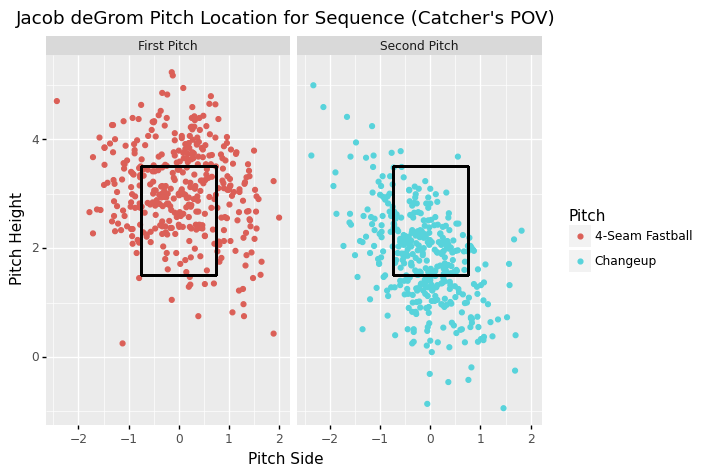

<ggplot: (-9223371902280645584)>

In [7]:
df = full_sequence('Jacob','DeGrom','4-Seam Fastball','Changeup')